In [11]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import torch
from torch import nn
import matplotlib.pyplot as plt
import sphericart.torch as sct
import numpy as np

### Implement Bessel radial basis layer

In [12]:
class SphericalBessel(nn.Module):
    def __init__(self, l_max: int = 1):
        super().__init__()
        self.l_max = l_max

        self.l = None
        self.m = None
        for i in range(l_max+1):
            if i ==0:
                self.l = torch.Tensor([0])
                self.m = torch.Tensor([0])
            else:
                m_array = torch.arange(-i, i+1)
                self.l = torch.cat((self.l, m_array*0+i))
                self.m = torch.cat((self.m, m_array))        

    def bessel_down(self, r, k):

        r = r.to(torch.float64)[...,None]*k.to(torch.float64)
        y = torch.zeros_like(r, dtype=torch.float64)

        lstart = self.l_max + int(torch.sqrt(torch.Tensor([10*self.l_max])))
        j2 = torch.zeros_like(r, dtype=torch.float64)
        j1 = torch.ones_like(r, dtype=torch.float64)

        for i in range(lstart, 0, -1):
            j0 = (2*i+1)/r * j1 - j2
            if i-1<self.l_max+1:
                y[..., i-1==self.l] = j0[..., i-1==self.l]
            j2 = j1
            j1 = j0

        true_j0 = torch.sinc(r/torch.pi)
        y = y / j0
        y = y * true_j0

        y[torch.logical_and(r<1e-20, self.l>0)] = 0
        y[torch.logical_and(r<1e-20, self.l==0)] = 1

        y = y*torch.sqrt(torch.Tensor([2])/torch.pi)*k
        return y.to(torch.float32)
    

    def bessel_up(self, r, k):

        r = r.to(torch.float64)[...,None]*k.to(torch.float64)
        y = torch.zeros_like(r, dtype=torch.float64)

        j0 =  torch.sin(r)/r
        y[..., self.l==0] = j0[..., self.l==0]

        j1 = j0/r - torch.cos(r)/r
        y[..., self.l==1] = j1[..., self.l==1]

        for i in range(1, self.l_max):
            j2 = (2*i+1)/r*j1 - j0
            y[..., self.l==i+1] = j2[..., self.l==i+1]
            j0 = j1
            j1 = j2

        y[torch.abs(r)<1e-30] = 0

        y = y*torch.sqrt(torch.Tensor([2])/torch.pi)*k
        return y.to(torch.float32)


    def forward(self, r, k):
        bessel_up = self.bessel_up(r, k)
        bessel_dwn = self.bessel_down(r, k)
        r = r[...,None]*k

        bessel_up[..., r<self.l] = bessel_dwn[..., r<self.l]

        return bessel_up

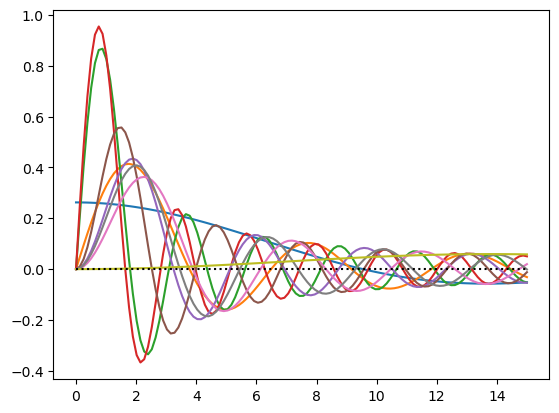

In [21]:
r = torch.linspace(0.0001,15,120)
bessel = SphericalBessel(l_max=2)
k = torch.rand(bessel.l.shape)*3
# k = (bessel.l+1 + bessel.l/2+bessel.m/5)*0.25
# k = (bessel.l+1)*0.25
# k = bessel.l*0+1
y = bessel(r, k)
plt.plot(r, y);
plt.plot([0,torch.max(r)],[0,0], ':k');

### Implement fourier series for time

In [4]:
class FourierModes(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, t, scale, phase):
        t = 2*torch.pi*(t.to(torch.float64)[...,None]*scale.to(torch.float64) - phase.to(torch.float64))
        
        return torch.cos(t).to(torch.float32)

torch.Size([200, 9])

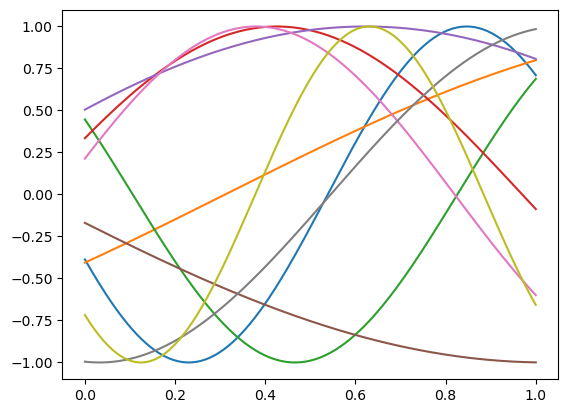

In [22]:
fourier = FourierModes()
t = torch.linspace(0,1,200)
scale = torch.rand(bessel.l.shape)*1
phase = torch.rand(bessel.l.shape)*1
y = fourier(t, scale, phase)
plt.plot(t, y)
y.shape

### Implement spherical harmonics for theta and phi

In [6]:
class SphericalHarmonicsModule(nn.Module):
    def __init__(self, l_max: int = 1):
        super().__init__()
        self.l_max = l_max
        self.sh = sct.SphericalHarmonics(l_max=self.l_max, normalized=True)

    def forward(self, xyz):
        sh_values = self.sh.compute(xyz)        
        return sh_values
       

In [7]:
theta = torch.linspace(1*torch.pi/180, torch.pi-1*torch.pi/180, 130)
phi = torch.linspace(0, 2*torch.pi, 260)

x = torch.sin(theta[:,None])*torch.cos(phi[None,:])
y = torch.sin(theta[:,None])*torch.sin(phi[None,:])
z = torch.cos(theta[:,None]).expand(x.shape)

xyz = torch.stack((x.reshape(-1), y.reshape(-1), z.reshape(-1)), dim=-1)

torch.Size([33800, 100])
torch.Size([130, 260, 100])


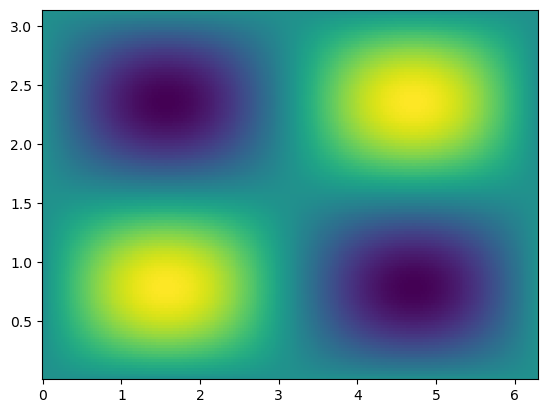

In [8]:
l_max = 9
spherical_harmonics = SphericalHarmonicsModule(l_max=l_max)
out = spherical_harmonics(xyz)
print(out.shape)

out = out.reshape([s for s in x.shape]+[out.shape[1]])
print(out.shape)
plt.pcolormesh(phi, theta, out[:,:,5])

### Implement orthonormal time spherical NeRF

In [298]:
class SplineLinear(nn.Linear):
    def __init__(self, in_features: int, out_features: int, init_scale: float = 0.1, **kw) -> None:
        self.init_scale = init_scale
        super().__init__(in_features, out_features, bias=False, **kw)

    def reset_parameters(self) -> None:
        nn.init.trunc_normal_(self.weight, mean=0, std=self.init_scale)

In [11]:
class OrthonormalTimeSphericalNeRF(nn.Module):
    def __init__(self,
                output_dim: int = 2, 
                l_max: int = 1, 
                spline_weight_init_scale: float = 0.1, 
                base_log_temperature: float = 5.0,
                base_log_density: float = 10.0):
        
        super().__init__()

        self.base_log_temperature = base_log_temperature
        self.base_log_density = base_log_density


        self.l_max = l_max

        self.r_bessel = SphericalBessel(l_max=l_max+1)
        self.sh = SphericalHarmonicsModule(l_max=l_max)
        self.t_fourier = FourierModes()

        self.radius_scale = nn.Parameter(torch.ones((l_max+1)*(l_max+1), dtype=torch.float32, requires_grad=True))
        self.time_scale = nn.Parameter(torch.ones((l_max+1)*(l_max+1), dtype=torch.float32, requires_grad=True))
        self.time_phase = nn.Parameter(torch.ones((l_max+1)*(l_max+1), dtype=torch.float32, requires_grad=True))


        # Absorption for AIA, referred to instrument 0, EUVI-A refers to instrument 1, EUVI-B refers to instrument 2
        self.log_absortpion = nn.Parameter(20.0*torch.tensor([[1.0, 1.0, 1.0],
                                                         [1.0, 1.0, 1.0],
                                                         [1.0, 1.0, 1.0],
                                                         [1.0, 1.0, 1.0],
                                                         [1.0, 1.0, 1.0],
                                                         [1.0, 1.0, 1.0],
                                                         [1.0, 1.0, 1.0]], dtype=torch.float32, requires_grad=True)) 

        # Tensor with volumetric constant for all instruments.
        #  Position 0 (AIA), position 1 (EUVIA), and position 2 (EUVB)
        self.volumetric_constant = nn.Parameter(torch.tensor([1., 1., 1.,], dtype=torch.float32, requires_grad=True)) 


    def forward(self, x):
        fourier = self.t_fourier(x[:, 3], self.time_scale, self.time_phase)
        bessel = self.r_bessel(torch.sqrt(x[:, 0]*x[:, 0] + x[:, 1]*x[:, 1] + x[:, 2]*x[:, 2]), self.radius_scale)
        sh = self.sh(x[:, 0:3].contiguous())

        # x = self.spline_linear((sh[:,:,:,None, None]*bessel[:,:,None,:, None]*fourier[:, None, None, None,:]).reshape(x.shape[0], -1))
        x = torch.abs(self.spline_linear(fourier*bessel*sh))
        
        # Add base density
        x[:, 0] = x[:, 0] + self.base_log_density
        # Add base temperature
        x[:, 1] = x[:, 1] + self.base_log_temperature

        return {'RhoT': x, 'log_abs': self.log_absortpion , 'vol_c': self.volumetric_constant}

In [12]:
xyzt = torch.rand([22, 4])
xyzt.shape

torch.Size([22, 4])

In [13]:
model = OrthonormalTimeSphericalNeRF(k_max = 20, l_max = 20, n_max = 20)
model(xyzt)

706020


{'inferences': tensor([[ 5.1807, -0.1338],
         [ 7.4542,  1.1354],
         [10.7283,  9.9813],
         [20.0970, 10.7337],
         [21.9734,  5.6100],
         [ 6.9297,  1.3250],
         [ 7.6216,  5.1583],
         [12.5217,  2.9193],
         [15.0487,  5.2820],
         [10.9913,  9.9922],
         [ 7.3833,  7.7669],
         [19.0130,  7.3532],
         [11.7158, -3.4680],
         [ 5.1477,  5.9190],
         [ 8.5012, 10.3139],
         [21.7313, 12.3218],
         [11.9100, 13.2361],
         [14.7726, 13.9273],
         [16.2817, 10.3811],
         [17.9306,  8.9787],
         [ 8.6158,  5.2911],
         [ 9.2595,  2.1640]], grad_fn=<CopySlices>),
 'log_abs': ParameterDict(
     (094): Parameter containing: [torch.FloatTensor of size ]
     (0131): Parameter containing: [torch.FloatTensor of size ]
     (0171): Parameter containing: [torch.FloatTensor of size ]
     (0193): Parameter containing: [torch.FloatTensor of size ]
     (0211): Parameter containing: [torch.

### Implement orthonormal time spherical NeRF using irregular solid harmonics

In [22]:
class TimeSolidSphericalNeRF(nn.Module):
    def __init__(self,
                output_dim: int = 2,
                l_max: int = 1, 
                n_max: int = 1,
                t_scale: float = 1,
                r_scale: float = 1,
                spline_weight_init_scale: float = 0.1, 
                base_log_temperature: float = 5.0,
                base_log_density: float = 10.0):
        
        super().__init__()

        self.base_log_temperature = base_log_temperature
        self.base_log_density = base_log_density

        self.l_max = l_max
        self.n_max = n_max
        self.t_scale = t_scale
        self.r_scale = r_scale

        self.sh = SphericalHarmonicsModule(l_max=l_max)
        self.t_fourier = FourierModes(n_max=n_max, scale=t_scale)

        self.spline_linear = SplineLinear((2*n_max+1)*(l_max+1)*(2*l_max+1), output_dim, spline_weight_init_scale)

        # Absorption for AIA, referred to instrument 0, EUVI-A refers to instrument 1, EUVI-B refers to instrument 2
        self.log_absortpion = nn.ParameterDict([
                                ['094',  torch.tensor(1.e-6, dtype=torch.float32)],
                                ['0131', torch.tensor(1.e-6, dtype=torch.float32)],
                                ['0171', torch.tensor(1.e-6, dtype=torch.float32)],
                                ['0193', torch.tensor(1.e-6, dtype=torch.float32)],
                                ['0211', torch.tensor(1.e-6, dtype=torch.float32)],
                                ['0304', torch.tensor(1.e-6, dtype=torch.float32)],
                                ['0335', torch.tensor(1.e-6, dtype=torch.float32)],
                                ['1171', torch.tensor(1.e-6, dtype=torch.float32)],
                                ['1195', torch.tensor(1.e-6, dtype=torch.float32)],
                                ['1284', torch.tensor(1.e-6, dtype=torch.float32)],
                                ['1304', torch.tensor(1.e-6, dtype=torch.float32)],
                                ['2171', torch.tensor(1.e-6, dtype=torch.float32)],
                                ['2195', torch.tensor(1.e-6, dtype=torch.float32)],
                                ['2284', torch.tensor(1.e-6, dtype=torch.float32)],
                                ['2304', torch.tensor(1.e-6, dtype=torch.float32)],
                        ])        

        self.volumetric_constant = nn.ParameterDict([
                                ['0', torch.tensor(1.0, dtype=torch.float32)],
                                ['1', torch.tensor(1.0, dtype=torch.float32)],
                                ['2', torch.tensor(1.0, dtype=torch.float32)],
                        ])

    def forward(self, x):
        fourier = self.t_fourier(x[:, 3])
        fourier[torch.isnan(fourier)] = 0
        sh = self.sh(x[:, 0:3].contiguous())
        l = torch.linspace(0, self.l_max, self.l_max+1)

        sh = sh*torch.pow((torch.sqrt(x[:, 0]*x[:, 0] + x[:, 1]*x[:, 1] + x[:, 2]*x[:, 2])/self.r_scale)[:, None, None], -l[None,:, None])
        sh[torch.isnan(sh)] = 0

        x = self.spline_linear((sh[:,:,:, None]*fourier[:, None, None,:]).reshape(x.shape[0], -1))
        
        # Add base density
        x[:, 0] = x[:, 0] + self.base_log_density
        # Add base temperature
        x[:, 1] = x[:, 1] + self.base_log_temperature

        if x.isnan().any():
            print('nan')

        return {'inferences': x, 'log_abs': self.log_absortpion , 'vol_c': self.volumetric_constant}

In [23]:
model = TimeSolidSphericalNeRF(l_max = 20, n_max = 20)
model(xyzt)

torch.Size([22, 21, 41])
torch.Size([22])
torch.Size([21])


{'inferences': tensor([[ 7.0456e+01,  2.9931e+01],
         [ 6.2412e+00,  5.9846e+00],
         [ 1.0448e+01,  4.6150e+00],
         [ 1.1293e+01,  4.3789e+00],
         [ 1.0743e+01,  3.6244e+00],
         [-4.4277e+03,  9.3579e+03],
         [ 9.8805e+00,  4.9038e+00],
         [-2.6475e+06,  4.9876e+06],
         [ 9.4227e+00,  5.0375e+00],
         [ 1.0191e+01,  5.5495e+00],
         [ 1.9592e+05,  1.9512e+04],
         [ 9.9142e+01, -2.4957e+01],
         [ 5.4931e+00, -2.7051e-01],
         [ 1.0986e+01,  2.8007e+00],
         [ 1.3401e+04,  3.0043e+04],
         [ 1.0705e+01,  4.3765e+00],
         [-2.6481e+00,  4.5375e+00],
         [ 2.0762e+01, -1.6501e+01],
         [-6.2267e+03,  1.0326e+04],
         [ 9.1854e+00,  3.5296e+00],
         [ 1.0057e+01,  4.9383e+00],
         [ 5.5641e+00,  1.3353e+01]], grad_fn=<CopySlices>),
 'log_abs': ParameterDict(
     (094): Parameter containing: [torch.FloatTensor of size ]
     (0131): Parameter containing: [torch.FloatTensor of s